# Expanded RNN Architecture Comparison for Stock Prediction

In [6]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

plt.style.use('fivethirtyeight')

## 1. Load Data & Identify Stocks

In [7]:
file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shannanl/sp500-dataset",
    file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

# --- Volatility Analysis ---
symbols = sorted(list(set([col.split('_')[0] for col in df.columns if '_' in col])))
returns_df = pd.DataFrame()
for symbol in symbols:
    close_col = f'{symbol}_close'
    if close_col in df.columns:
        returns_df[symbol] = df[close_col].pct_change()

volatility = returns_df.std().sort_values(ascending=False)
high_vol_stocks = volatility.head(2).index.tolist()
low_vol_stocks = volatility.tail(2).index.tolist()
stocks_to_analyze = high_vol_stocks + low_vol_stocks

print(f"High volatility stocks: {high_vol_stocks}")
print(f"Low volatility stocks: {low_vol_stocks}")
print(f"Stocks to analyze: {stocks_to_analyze}")

/tmp/ipykernel_292321/4169323827.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_292321/4169323827.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

High volatility stocks: ['ENPH', 'MRNA']
Low volatility stocks: ['GIS', 'JNJ']
Stocks to analyze: ['ENPH', 'MRNA', 'GIS', 'JNJ']


/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

## 2. Define Helper Functions & Model

In [8]:
def create_sequences(data, target, time_steps=60):
    """Create sequences of data for RNN."""
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

def build_rnn_dense_model(input_shape):
    """Builds the 'Simple_RNN_2_Layers_Dense' model."""
    model = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(units=50),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## 3. Train Model and Store Predictions for Visualization

In [9]:
visualization_data = {}
time_steps = 60
epochs = 20
batch_size = 32

for stock in stocks_to_analyze:
    print(f'\n--- Processing {stock} for visualization ---')

    # Prepare and scale data
    df_stock = utils.load_comp_data(df, stock)
    df_stock_fe = utils.compute_features(df_stock, w=20, cut=False)
    target = df_stock_fe['log_next_day_max_return']
    features = df_stock_fe.drop(columns=["timestep", "log_next_day_max_return"])
    features.fillna(0, inplace=True)
    target.fillna(0, inplace=True)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_features = scaler.fit_transform(features)

    split_index = int(0.8 * len(df_stock_fe))
    train_features, test_features = scaled_features[:split_index], scaled_features[split_index:]
    train_target, test_target = target.iloc[:split_index], target.iloc[split_index:]
    test_timestamps = df_stock_fe.index[split_index:]

    # Create Sequences
    X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
    X_test, y_test = create_sequences(test_features, test_target.values, time_steps)
    
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Not enough data for {stock}. Skipping.")
        continue
        
    # Build, train, and predict
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rnn_dense_model(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    y_pred = model.predict(X_test)
    
    # Store results for plotting
    visualization_data[stock] = {
        'y_test': y_test,
        'y_pred': y_pred.flatten(),
        'timestamps': test_timestamps[time_steps:]
    }
    print(f'Finished processing {stock}.')

/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)



--- Processing ENPH for visualization ---


/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Finished processing ENPH.

--- Processing MRNA for visualization ---


/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Finished processing MRNA.

--- Processing GIS for visualization ---


/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-15 19:32:25.160617: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26983920 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Finished processing GIS.

--- Processing JNJ for visualization ---


/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-15 19:33:07.821530: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26983920 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Finished processing JNJ.


## 4. Visualize Model Failure

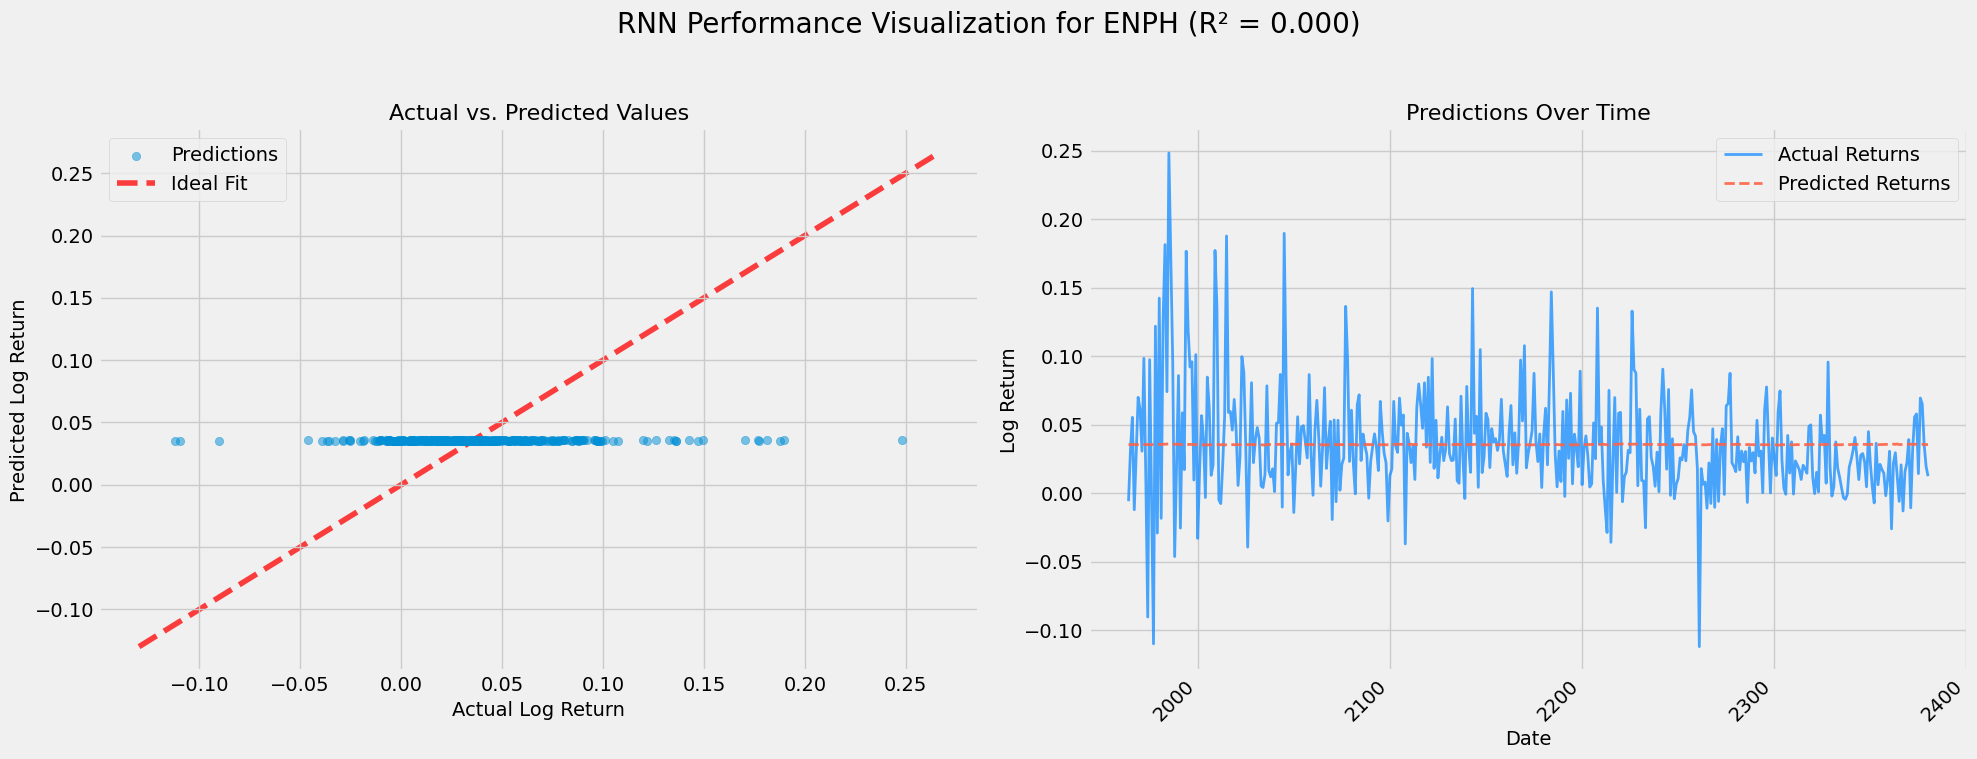

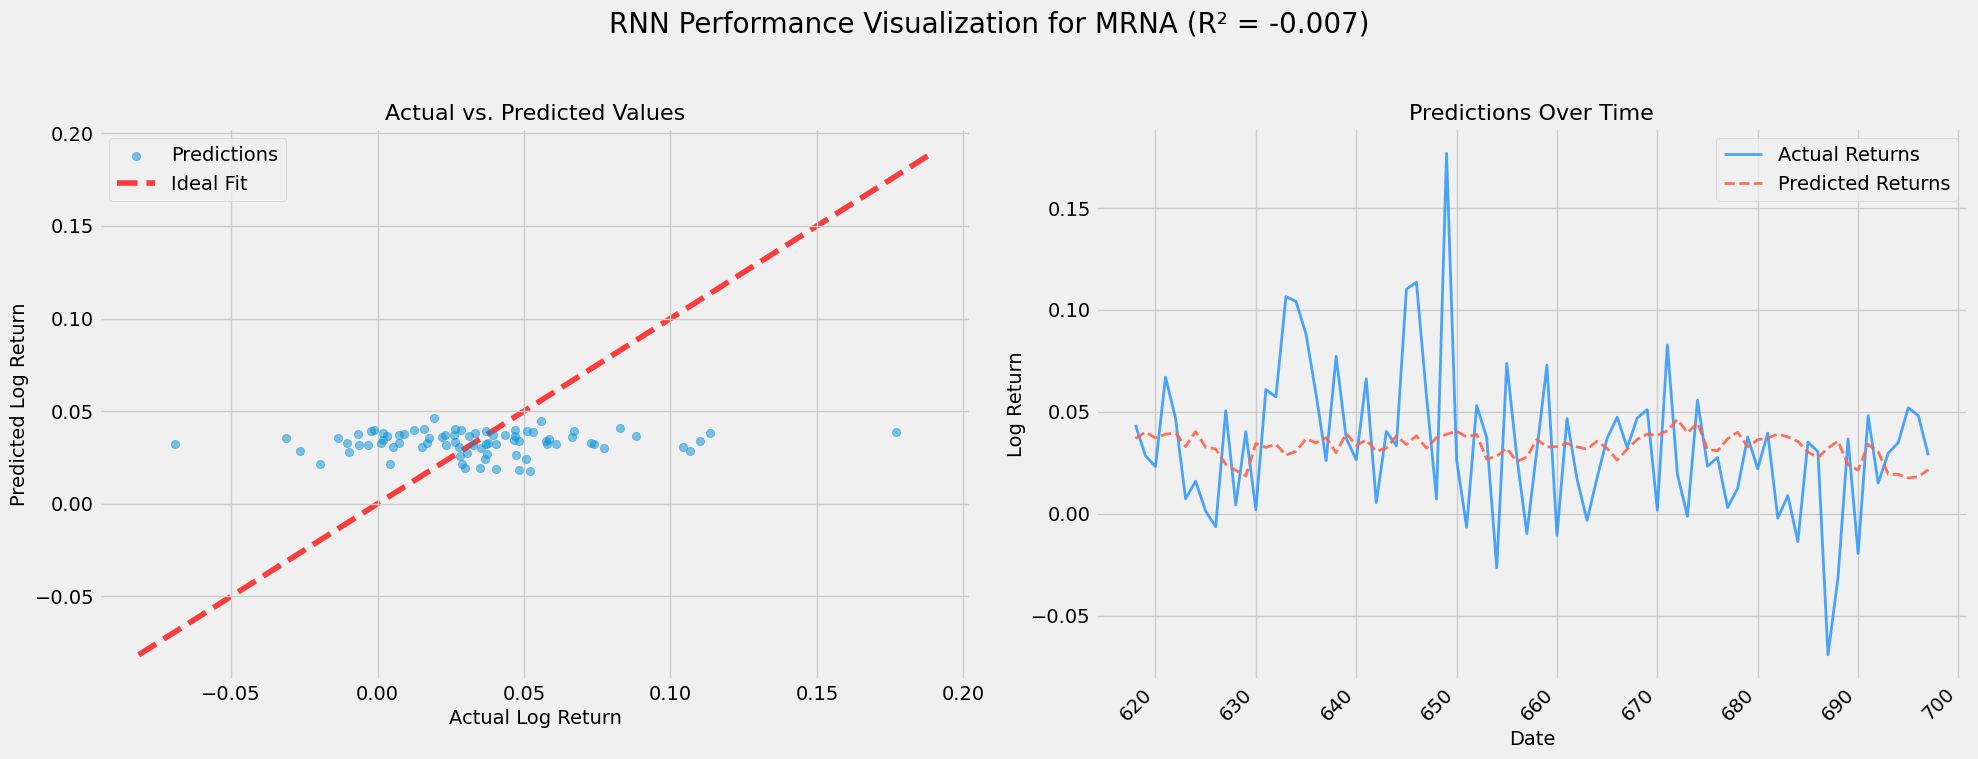

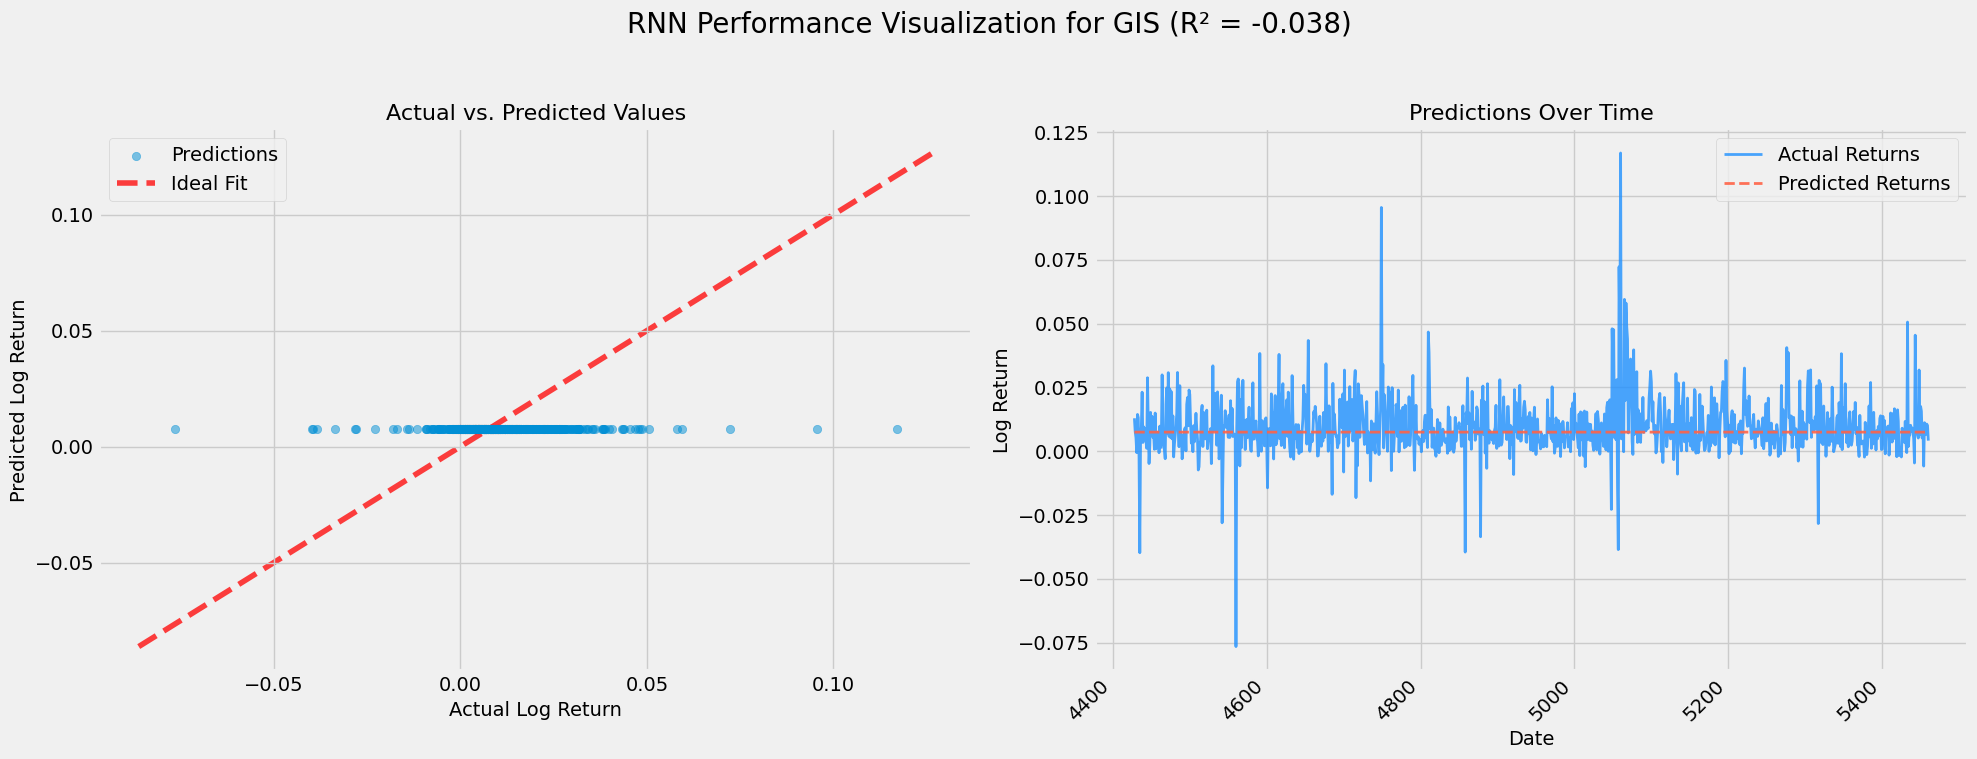

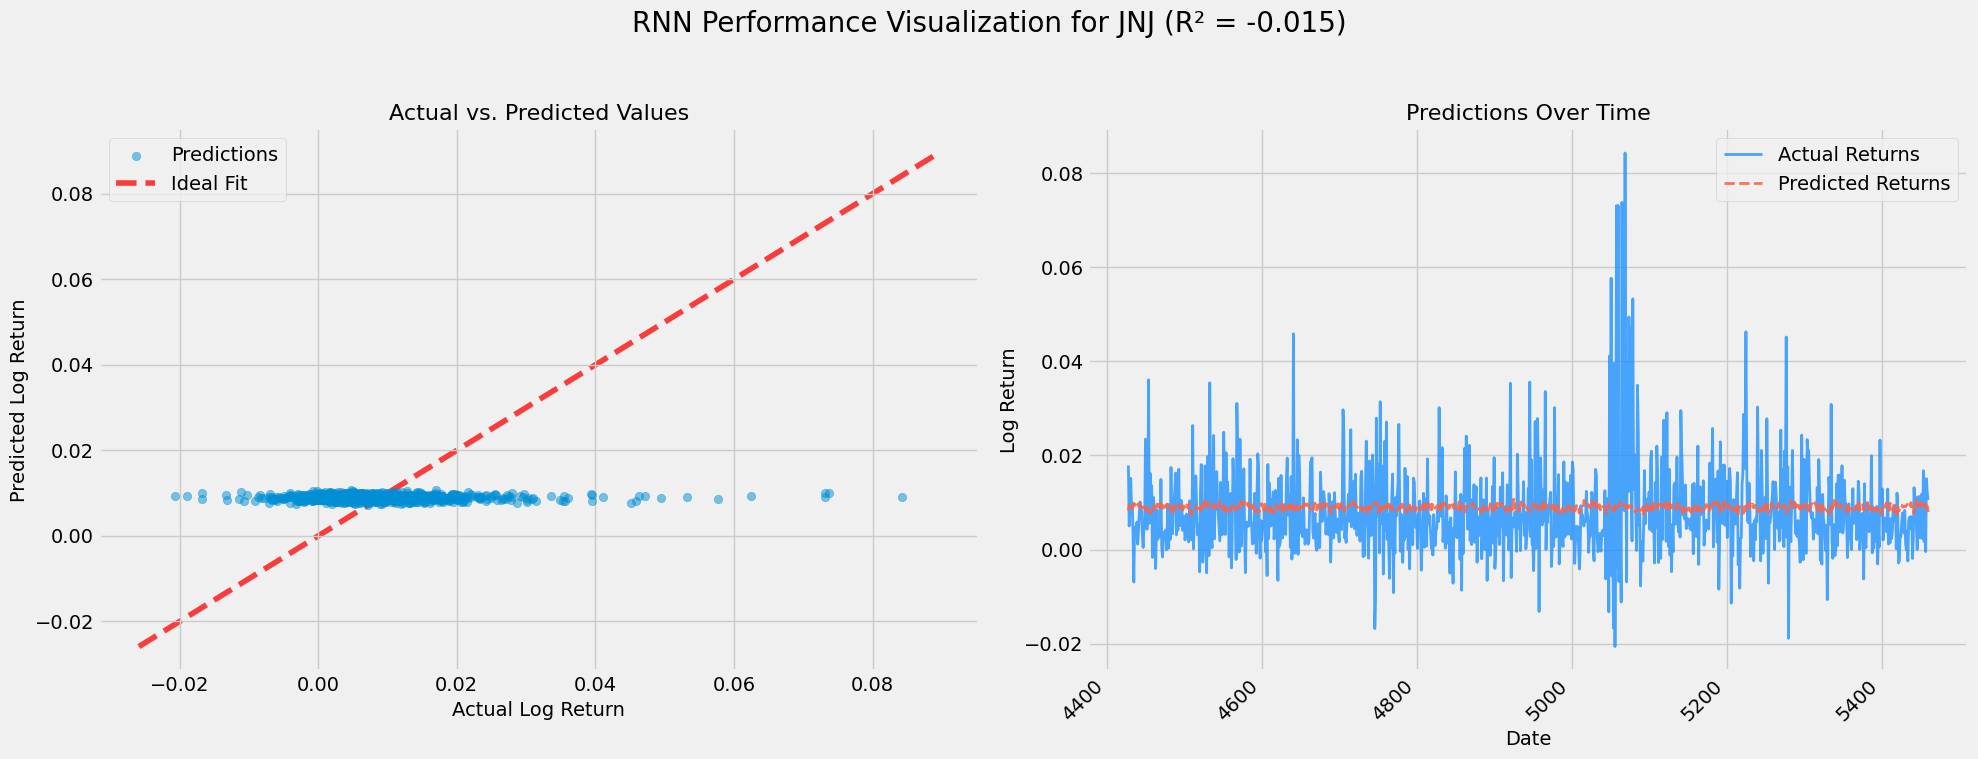

In [10]:
for stock, data in visualization_data.items():
    y_test = data['y_test']
    y_pred = data['y_pred']
    timestamps = data['timestamps']
    r2 = r2_score(y_test, y_pred)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'RNN Performance Visualization for {stock} (R² = {r2:.3f})', fontsize=20)

    # --- Subplot 1: Actual vs. Predicted Scatter Plot ---
    ax1.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
    # Add the ideal 45-degree line
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),
        np.max([ax1.get_xlim(), ax1.get_ylim()]),
    ]
    ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Ideal Fit')
    ax1.set_xlabel('Actual Log Return', fontsize=14)
    ax1.set_ylabel('Predicted Log Return', fontsize=14)
    ax1.set_title('Actual vs. Predicted Values', fontsize=16)
    ax1.legend()
    ax1.grid(True)

    # --- Subplot 2: Time Series Plot ---
    ax2.plot(timestamps, y_test, label='Actual Returns', color='dodgerblue', linewidth=2, alpha=0.8)
    ax2.plot(timestamps, y_pred, label='Predicted Returns', color='tomato', linestyle='--', linewidth=2, alpha=0.9)
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Log Return', fontsize=14)
    ax2.set_title('Predictions Over Time', fontsize=16)
    ax2.legend()
    ax2.grid(True)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()